last updated 11 03 24

This notebook is to get the run times for each model on the highets and lowest Resolutions; to estimate an average run time.IG DICITONARY!



In [1]:
#!pip install ipython

In [2]:
# imports
import torch

import torch.nn as nn
from torchvision.models import vgg16
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from torchvision.models import vgg16
from torch.utils.data import DataLoader
#from torch.Utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

import numpy as np
import cv2


from datetime import date
from tqdm import tqdm
import pprint
import collections
from IPython.display import clear_output
#import time
import random
import cv2

import csv
import json
import pickle
import os

import wandb

import sys
sys.path.append('../.')
from functions import import_imagedata, ImageProcessor, label_oh_tf, IDSWDataSetLoader2
from fns4wandb import set_lossfn

from loop_fns import loop#, loop_batch, test_loop_batch
from plotting import learning_curve, accuracy_curve, plot_confusion

from torchvision.models import vgg16


#import torch.Utils.data.DataLoader as DataLoader

In [3]:
#p = torch.cuda.memory_summary(device, abbreviated=False)
#Pp = pprint.PrettyPrinter(indent=4)
#Pp.pprint(p)

In [4]:
# file paths
optimmy = 'SGD'
model_type = 'vgg16'

_save_location = f'/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/{model_type}/{optimmy}/RoP/' 
checkpoint_saveloc = f"/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/{model_type}/{optimmy}/modelCheckPoints/"

data_path = r'/its/home/nn268/antvis/antvis/optics/AugmentedDS_IDSW/'

gitHASH = '682f9e66a8c166dc9c1b3de71e8e9f2c72d35ed2'


start_epoch = 150
epoch_val =  300# 150

Var_WB_sched = "RoP"

loadPreTrainedModel = True

In [5]:
#wandb.login()
#wandb login --relogin
wandb.agent

<function wandb.wandb_agent.agent(sweep_id, function=None, entity=None, project=None, count=None)>

In [6]:
# dictionaries                                                                                  * * * *   SETTINGS   * * * *

date = date.today()
#model_name = model_card['model']
model_card_vgg = {'name': 'vgg', 'model': 'vgg16',
                  'f_lin_lay':[200704,#200704,     #129024,#4096,  # (32x200704 and 3584x4096)
                             200704,      #(16x64512 and 129024x4096)    (16x200704 and 64512x4096)
                             200704,#14336#(16x200704 and 14336x4096)
                             200704,
                             200704, ##(32x200704 and 3584x4096)
                             200704,
                             200704,
                            ],
                 'idx': 0,
                 'dropout':0.2}



resolution_card_452144 = {'resolution':[452,144], 'padding':5, 'index':0}
resolution_card_22672 = {'resolution':[226,72], 'padding':5, 'index':1}
resolution_card_11336 = {'resolution':[113,36], 'padding':2, 'index':2}
resolution_card_5715 = {'resolution':[57,18], 'padding':1, 'index':3}

resolution_card_299 = {'resolution':[29,9], 'padding':0, 'index':4} # 
resolution_card_155 = {'resolution':[15,5], 'padding':0, 'index':5}
resolution_card_83 = {'resolution':[8,3], 'padding':0, 'index':6}



resolution_cards = [resolution_card_452144, resolution_card_11336, resolution_card_5715, resolution_card_155]#]#resolution_card_452144, resolution_card_22672, resolution_card_11336, 
#resolution_card_452144, resolution_card_22672, resolution_card_11336, resolution_card_5715,resolution_card_299, resolution_card_155,
#resolution_cards = [resolution_card_11336] #resolution_card_452144, resolution_card_22672, resolution_card_11336, resolution_card_5715,resolution_card_299, resolution_card_155, resolution_card_83

#learning_rate_cards = [5e-5, 6e-5, 8e-5]
#learning_rate_cards = [8.21592E-05, 6.62E-05, 6.01E-05, 5.97E-05]
learning_rate_cards=  [1e-3] #[0.1, 0.01, 1e-3,1e-4, 1e-5]#, 6e-5, 7e-5, 8e-5]
#wd_cards = [4e-5, 5e-5, 3.00E-05, 2.00E-05]
wd_cards =[0]
scheduler_cards = [0]#, 0.1, 0.2]

seeds = [8,2,4,42]# 8

#model_cards =[model_card_vgg, model_card_7c3l, model_card_4c3l, model_card_3c2l, model_card_2c2l]
model_cards =[model_card_vgg]

loss_fn_cards = ['CrossEntropy']# ,'MSE'] #
                        
config = dict({'parameters': 'parameters for big loop run'})
config.update({'model_cards':model_cards})
config.update({'resolution_cards':resolution_cards})
config.update({'learning_rate_cards':learning_rate_cards})
config.update({'wd_cards':wd_cards})
config.update({'scheduler_cards':scheduler_cards})
config.update({'seeds':seeds})
config.update({'loss_fn_cards': loss_fn_cards})


config.update({'batch_size': 32}) #64
config.update({'epochs': epoch_val})
config.update({'start_epoch': start_epoch})

#print(model_card_vgg)
#print('')
#Pp.pprint(Config) # dictionary of dictionaries of lists and lists of dictionaries

452 144 5/452 *100 = 1%
226 72 5/226 *100 = 2%
113 36 5/113 *100 = 4% -- 2/113 *100= 1.7% ~ 2%
57 18 (56.5,) 5/57 *100 = 8% -- 2/57 *100 = 3.5% ~ 4%. 1/57 = 1.75%
29 9 (28.5,) 5/29 *100 = 17% -- 2/29 *100 = 6.89 ~ 7% 1/28 = 3.57 ~ 4%
15 5 (14.5, 4.5)
8 3 (7.5,2.5)
4, 2 (, 1.5)

In [7]:
   

Pp = pprint.PrettyPrinter(indent=4)

def save2csv_nest_dict(nested_dict, file_name, save_location:str):
    # flattern nested dictionary
    flatterend_dict = {}
    for k,v in nested_dict.items():
        if isinstance(v, dict):
            for nested_key, nested_val in v.items():
                flatterend_dict[f"{k}_{nested_key}"] = nested_val
        else:
            flatterend_dict[k] =v
    
    columns = list(flatterend_dict.keys())
    
    with open(save_location+str(file_name)+'.csv', "a+", newline="") as f:
        # using dictwriter
        writer = csv.DictWriter(f, fieldnames=columns)
        # using writeheader function
        if f.tell() == 0:
            writer.writeheader()
        writer.writerow(flatterend_dict)
        f.close()

# check dictionary values for json and csv

def check_obj4np(obj):
    if isinstance(obj, dict):
        return {key: check_obj4np(value) for key, value in obj.items()}
    if isinstance(obj,list):
        return [check_obj4np(item) for item in obj]
    if isinstance(obj,np.ndarray):
        return obj.tolist()
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    else:
        return obj

# save to json
def save2josn_nested_dict(nested_dict, file_name, save_location:str):
    nested_dict = check_obj4np(nested_dict)
    json_obj = json.dumps(nested_dict, indent=4)
    with open(save_location+str(file_name)+'.json', 'a+') as f:
        f.write(json_obj)
        f.close()

    
#save_location+str(file_name)+'.csv'
def save2csv(nested_dict, file_name, save_location:str):
    
    nested_dict = check_obj4np(nested_dict)
    
    columns = list(nested_dict.keys())
    path = os.path.join(save_location, file_name +".csv")
    try:
        with open(path, "a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=columns)
            # using dictwriter
            # using writeheader function
            if f.tell() == 0:
                writer.writeheader()
            writer.writerow(nested_dict)
            f.close()
    except IOError as e:
        print("I/O error({0}): {1}".format(e.errno, e.strerror))
    except ValueError:
              print("could not convert to string")
    except:
              print("unexpected error: ", sys.exc_info()[0])
        

def save2json(nested_dict, file_name, save_location:str):
    nested_dict = check_obj4np(nested_dict)
    #print(nested_dict)
    #print(nested_dict.items())
    json_obj = json.dumps(nested_dict, indent=4)
    #print(json_obj)
    path = os.path.join(save_location, file_name+".json")
    #print(path)
    with open(path, 'w') as f:
        f.write(json_obj)
        
        


def read_in_json(file_path, file_name):
    path = os.path.join(file_path, 'file_name')
    try:
        with open(path, 'r') as f:
            #obj = f.read()
            dj = json.load(f, object_pairs_hook= collections.OrderedDict) #obj, 
            #print(dj)
    except Exception as e:
        print("Error decoding Json")
        print(e)


class Flattern(nn.Module):
    def __init__(self):
        super(Flattern, self).__init__()
    def forward(self, x):
        #print(x.shape)
        x = x.flatten()
        return x


def choose_model(model_name, lin_lay, dropout):

    if model_name == '4c3l':
        return smallnet1(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == '3c2l':
        return smallnet2(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks = (3,5), dropout=dropout)
    elif model_name == '2c2l':
        return smallnet3(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == '7c3l':
        return sevennet(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == 'vgg16':
        #self.flatten = nn.Flatten()
        model_vgg16 = vgg16()
        vgg_feats = model_vgg16.features
        vgg_classifier = model_vgg16.classifier
        vgg_classifier.pop(6)

        vgg = nn.Sequential(
            vgg_feats,
            nn.Flatten(),
            vgg_classifier,
            nn.Linear(4096,11), # cheanging the output layer
            nn.Softmax(dim=0),  
            )
        
        #del model_vgg16
        return vgg
    else:
        print('Model Name Not Recognised')




def check_model_sizes_bits(model):
    bits = 32
    mods = list(model.modules())
    sizes = []
    total_bits = 0
    
    for i in range(1,len(mods)):
        m = mods[i]
        p = list(m.parameters())
        for j in range(len(p)):
            sizes.append(np.array(p[j].size()))
    
    for i in range(len(sizes)):
        s = sizes[i]
        bitz = np.prod(np.array(s))*bits
        total_bits += bitz
    total_bytes = total_bits/8
    total_megabytes = total_bytes/1e+6
    total_gigabytes = total_megabytes/1000
    print(total_bits, 'bits    ', total_bytes, "bytes    ", total_megabytes, "MegaBytes    ", total_gigabytes,"GigaBytes") # 148480


def ptrblk_fin_mod_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    size_all_gb = size_all_mb/953.674
    print('model size: {:.3f}MB'.format(size_all_mb))
    print('model size: {:.3f}GB'.format(size_all_gb))




In [8]:

def train_val_batch(model, train, val, loop_run_name, save_dict, lr, loss_fn, epochs, batch_size, optimizer, scheduler_value, device): #train_dl, val_dl, 
    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3) 
    model.train()
    

    t_loss_list = []
    v_loss_list = []
    t_predict_list = []
    v_predict_list = []
    t_accuracy_list = []
    v_accuracy_list = []
    t_label_list = []
    v_label_list = []
    #labels = []
    sample = False
    
    
    total_epochs = 0
    for epoch in tqdm(range(save_dict['start_epoch'],epochs)):

        random_value = random.randrange(0,batch_size)
        #sample = False

        
        print('Training...')

        
        t_loss, train_prediction, train_targets, t_correct, model, optimizer = loop_batch(model, train, loss_fn, batch_size,sample,random_value,epoch,loop_run_name, save_dict, device, optimizer =optimizer, scheduler= scheduler_value, train =True) #, scheduler =scheduler
        print('training..  2')
        #!nvidia-smi
        
        t_loss_list.append(t_loss)
        [t_predict_list.append(pred.argmax()) for pred in train_prediction]
        wandb.log({'t_loss':t_loss})
    
        train_acc = (t_correct/(len(train)*batch_size)*100) ###
        print('train accuracy: ', train_acc )
        t_accuracy_list.append(train_acc)
        wandb.log({'train_acc':train_acc})
        
        
            
        print('validating...')
        #!nvidia-smi
        
        v_loss, val_prediction, val_targets, val_correct= loop_batch(model, val, loss_fn, batch_size,sample,random_value,epoch,loop_run_name, save_dict, device, optimizer =None, scheduler= None, train =False)

        v_loss_list.append(v_loss)
        [v_predict_list.append(pred) for pred in val_prediction]
        wandb.log({'v_loss':v_loss})
        
        val_acc = (val_correct/(len(val)*batch_size)*100)
        v_accuracy_list.append(val_acc)
        print('validation accuracy: ', val_acc )
        wandb.log({'val_acc':val_acc})
    
        total_epochs += 1

        if epoch %25==0 and epoch !=0 and epoch != int(save_dict['start_epoch']):
            #checkpoint = copy.deepcopy(model)
            checkpoint_id = f"{model_type}_{optimmy}_{Var_WB_sched}_{epoch}E_{save_dict['res']}_seed{save_dict['seed']}"
            torch.save(model.state_dict(), checkpoint_saveloc+checkpoint_id, pickle_module=pickle)
            learning_curve(t_loss_list, v_loss_list, save_location=checkpoint_saveloc,run_name=checkpoint_id)
            accuracy_curve(t_accuracy_list, v_accuracy_list,save_location=checkpoint_saveloc,run_name=checkpoint_id)
            #plot_confusion(predictions= test_predict_list, actual= y_test, title = "Test Confusion matrix", run_name = checkpoint_id,save_location =checkpoint_saveloc)
        clear_output()
        
    save_dict['Current_Epoch'] = epochs
    save_dict['training_samples'] = len(train)
    save_dict['validation_samples'] = len(val)
    
    save_dict['t_accuracy_list'] = t_accuracy_list 
    save_dict['v_accuracy_list'] = v_accuracy_list  #
            
    #model = best_model
    save_dict['t_loss_list'] = t_loss_list
    save_dict['v_loss_list'] = v_loss_list
    
    save_dict['t_labels'] = train_targets
    save_dict['v_labels'] = val_targets
    
    save_dict['t_predict_list'] = t_predict_list 
    save_dict['v_predict_list'] = v_predict_list  #
    
    return model, save_dict

from functions import ImageProcessor

def loop_batch(model, data, loss_fn, batch_size, sample,random_value,epoch,loop_run_name, save_dict, device, optimizer =None, scheduler= None, train =True):	# Train and Val loops. Default is train
    model = model
    total_samples = len(data)
    if optimizer:
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=10)#lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_value) 
    if train:
        model.train()
        #where ='tra'
        #lr_ls = []
    else:
        model.eval()   #  (torch.Size([16, 11])) that is different to the input size (torch.Size([11]))
        #where = 'val'

    predict_list = []
    total_count = 0
    num_correct = 0
    current_loss = 0
    labels =[]

    
    for i, batch in enumerate(data,0):

        x_batch, y_batch = batch
        
        prediction = model.forward(x_batch)
        del x_batch

        loss = loss_fn(prediction, y_batch)

        if train:
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        
        for i in range(len(y_batch)-1):

            if y_batch[i].argmax() == prediction[i].argmax():
                num_correct +=1
            [predict_list.append(pred.argmax()) for pred in prediction]#.argmax())
            [labels.append(y.argmax()) for y in y_batch]

        total_count+= batch_size
        current_loss += loss.item()
        
    if scheduler:
        scheduler.step(loss)
    
    if train:
        return current_loss, predict_list, y_batch, num_correct, model, optimizer #, lr_ls
    else:
        return current_loss, predict_list, y_batch, num_correct


## model, data, loss_fn, device, optimizer =None, scheduler= None, train =True
def test_loop_batch(model,data, loss_fn, batch_size, device):
    model = model.eval()
    predict_list = []
    label_list = []
    total_count =0
    num_correct = 0
    correct = 0
    

    with torch.no_grad():
        for i, batch in enumerate(data,0):
            #tense = tense.to(device)
            tense, label = batch
            label = label.to(device)
            
            prediction = model.forward(tense.to(device))
            for i in range(len(label)-1):
                #print(len(label), label[0].argmax(), len(label)-1)
                if label[i].argmax() == prediction[i].argmax():
                    num_correct +=1
            [predict_list.append(pred.argmax()) for pred in prediction]
            [label_list.append(lab.argmax()) for lab in label]

            total_count += batch_size
            #correct +=(prediction.argmax()==label.argmax()).sum().item()
    
        acc = num_correct/total_count
        accuracy = 100*(acc)

        print(accuracy)

        return accuracy, predict_list, label_list



def get_data(random_seed):
    file_path =  data_path
    #print(file_path)
    img_len = len(os.listdir(file_path))
    
    x, y = import_imagedata(file_path)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, train_size=0.7,
                                     random_state=random_seed, shuffle=True)
    x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.3, train_size=0.7,
                                     random_state=random_seed, shuffle=True)

    return x_train, y_train, x_val, y_val, x_test, y_test


    
def get_lin_lay(model_card, resolution):
    if resolution == [452, 144]:
        lin_lay = model_card['f_lin_lay'][0]
    elif resolution == [226, 72]:
        lin_lay = model_card['f_lin_lay'][1]
    elif resolution == [113, 36]:
        lin_lay = model_card['f_lin_lay'][2]
    elif resolution == [57, 18]:
        lin_lay = model_card['f_lin_lay'][3]
    elif resolution == [29, 9]:
        lin_lay = model_card['f_lin_lay'][4]
    elif resolution == [15, 5]:
        lin_lay = model_card['f_lin_lay'][5]
    elif resolution == [8, 3]:
        lin_lay = model_card['f_lin_lay'][6]
    else:
        print("PARAMETER NOT FOUND: \n f_lin_lay FROM MODEL CARD")
    return lin_lay


In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"


def _go(config=None):

    if len(gitHASH) <1:
        print("YOU FORGET THE GIT HASH")
        return
    else:
        #print('Git Hash registered')
        pass
        
    with wandb.init(config=config, project=f"{model_type} {epoch_val}E. {Var_WB_sched}. {optimmy}", notes=f"{model_type} {epoch_val}E {Var_WB_sched} {optimmy}",):
        config = wandb.config
        #start = time.process_time()
            
        model_card = model_card_vgg
        #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                
        model_name = model_card['model']
        model_index = model_card['idx']
        dropout = model_card['dropout'] 
        for res_idx, resolution_card in enumerate(config['resolution_cards']):
            #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
            resolution = resolution_card['resolution']
            pad = resolution_card['padding']
            lin_lay = get_lin_lay(model_card, resolution)
            print('lin lay', lin_lay)
            scheduler_value = 0
        
            lr = 1e-3#for lr_idx, lr in enumerate(config['learning_rate_cards']):
                
                   
            for seed_idx, seed in enumerate(config['seeds']):
                seed = seed
                loss = 'CrossEntropy'
                                
                torch.cuda.empty_cache()
                #print('2')
                #!nvidia-smi

                config['batch_size']

                print('Model: ', str(model_name), f" idx: {0} / {len(config.model_cards)}")
                print('resolution: ', str(resolution), f" idx: {res_idx} / {len(config['resolution_cards'])}")
                print('learning rate: ', str(lr), f" idx: {0} / {len(config['learning_rate_cards'])}")
                #print('weight decay: ', str(wd_card), f" idx: {wd_idx} / {len(config['wd_cards'])}")
                #print('scheduler: ', str(scheduler_value), f" idx: {sched_idx} / {len(config['scheduler_cards'])}")
                print('seed: ', str(seed), f" idx: {seed_idx} / {len(config['seeds'])}")
                print('loss function: ', str(loss))#, f" idx: {0} / {len(config['loss_fn_cards'])}")
                print('Batch size: ', config['batch_size'])
                print('Training epochs: ', config['epochs'])
                #run_start_time = time.process_time()
                #print('start time: ',run_start_time)

                #print(time.process_time() - start)
                

                epochs = config['epochs'] #40

                IP = ImageProcessor(device)

                wandb.log({'gitHash':gitHASH})
                wandb.log({'Epochs': epochs})
                
                #print('3')
                #!nvidia-smi
                
                # set save dictionary
                save_dict = {'Run' : f"{model_name}_{resolution}_{date}_{optimmy}_{config['epochs']}E_{Var_WB_sched}",
                             'Current_Epoch': config['start_epoch'], # this is where i add the start epoch
                             'start_epoch':config['start_epoch'],
                             'save_location' : _save_location,
                             'res': resolution,
                             'sched': Var_WB_sched,
                             'model': model_name,
                             'seed':seed}

                model = choose_model(model_name, lin_lay, dropout).to(device)
                if loadPreTrainedModel:
                    dir_pkl = f"/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/{model_type}/{optimmy}/{Var_WB_sched}/"
                    pkl_name = f"{model_type}_{resolution}_2024-11-26_{optimmy}_150E_{Var_WB_sched}_{resolution}_0.001_{seed}_CrossEntropy_{optimmy}.pkl"
                    #model_pkl = torch.load(dir_pkl+pkl_name)
                    with open(dir_pkl+pkl_name, 'rb') as f:
                        model_pkl = torch.load(f)
                    #model_pkl = pickle.load(dir_pkl+pkl_name)
                    model.load_state_dict(model_pkl['model.state_dict'])
                    
                print(torch.cuda.memory_summary(device=device, abbreviated=False))
                print("After model init, Before data loading - Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)

                x_train, y_train, x_val, y_val, x_test, y_test = get_data(seed)
                av_lum = IP.new_luminance(x_train)

                train_ds = IDSWDataSetLoader2(x_train, y_train, resolution,pad,av_lum,model_name, device)# av_lum, res,pad,
                train = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, drop_last=True) #, num_workers=2
                
                test_ds = IDSWDataSetLoader2(x_test, y_test, resolution,pad,av_lum,model_name, device)
                test = DataLoader(test_ds, batch_size=config['batch_size'], shuffle=True, drop_last=True) #, num_workers=2
                val_ds = IDSWDataSetLoader2(x_val, y_val, resolution,pad,av_lum,model_name, device)
                val = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=True, drop_last=True) #, num_workers=2
                
                print("After data loading - Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                loss_fn = set_lossfn(loss)
                
                # set optimizer
                optimizer =torch.optim.SGD(model.parameters(), lr=lr)#torch.optim.Adam(model.parameters(),lr=lr)

                wandb.watch(model, loss_fn, log='all', log_freq=2, idx = model_index)

                loop_run_name = f"{save_dict['Run']}_{resolution}_{lr}_{seed}_{loss}_{optimmy}"

                model, save_dict=  train_val_batch(model, train,val, loop_run_name,save_dict, lr, loss_fn,epochs, config['batch_size'], optimizer, scheduler_value, device)

                test_acc,test_predict_list, y_test = test_loop_batch(model,test, loss_fn, config['batch_size'], device) #model, model_name, X, Y, res, pad, loss_fn, device, num_classes=11
                
                #print(test_predict_list)
                print(' \n train Acc: ', save_dict['t_accuracy_list'][-1])
                print(' \n val Acc: ', save_dict['v_accuracy_list'][-1])
                print(' \n test Acc: ', test_acc)
                
                save_dict.update({'test_acc': test_acc})
                save_dict.update({'test_predict': test_predict_list})
                save_dict.update({'test_labels': list(y_test)})

                learning_curve(save_dict['t_loss_list'], save_dict['v_loss_list'], save_location=save_dict['save_location'],run_name=loop_run_name)
                accuracy_curve(save_dict['t_accuracy_list'], save_dict['v_accuracy_list'],save_location=save_dict['save_location'],run_name=loop_run_name)
                test_predict_list=[pred.cpu() for pred in test_predict_list]
                plot_confusion(predictions= test_predict_list, actual= y_test, title = "Test Confusion matrix", run_name = loop_run_name,save_location =save_dict['save_location'])
                
                wandb.log({'test_acc': test_acc})
                wandb.log({'test_predict': test_predict_list})
                wandb.log({'test_labels': list(y_test)})
                #saving
                diction = {}
                d = date.today()
                d=str(d)
                diction.update({'Date':d})
                diction.update({'gitHASH':str(gitHASH)})
                diction.update({'model_name': str(model_name)})
                diction.update({'loss_fn': str(loss)})
                diction.update({'lr': str(lr)})
                #diction.update({'wd': str(wd_card)})
                #diction.update({'scheduler value': str(scheduler_value)})
                diction.update({'seed': str(seed)})
                diction.update({'resolution': str(resolution)})
                diction.update({'pad': int(pad)})
                diction.update({'lin_lay': int(lin_lay)})
                #diction.update({'run time': (time.process_time() - run_start_time)})
                diction.update(save_dict)
                
                save_location = save_dict['save_location']
                title = save_dict['Run']
                save2json(diction, loop_run_name, save_location)
                save2csv(diction, title, save_location)

                diction['model.state_dict'] = model.state_dict() #to('cpu').

                with open(f"{save_location}{loop_run_name}.pkl", 'wb+') as f:
                    #p
                    torch.save (diction, f)
                
                clear_output()

                
                #print(f' \n END {model_name} {resolution} Run Time: ',time.process_time() - run_start_time)
                #!nvidia-smi
                torch.cuda.empty_cache()
        #print('Final Run time: ',time.process_time() - start)
        torch.cuda.empty_cache()
        del save_dict
        del config
        del diction

100%|█| 150/150 [24:51<0


17.7734375
 
 train Acc:  10.15625
 
 val Acc:  17.045454545454543
 
 test Acc:  17.7734375


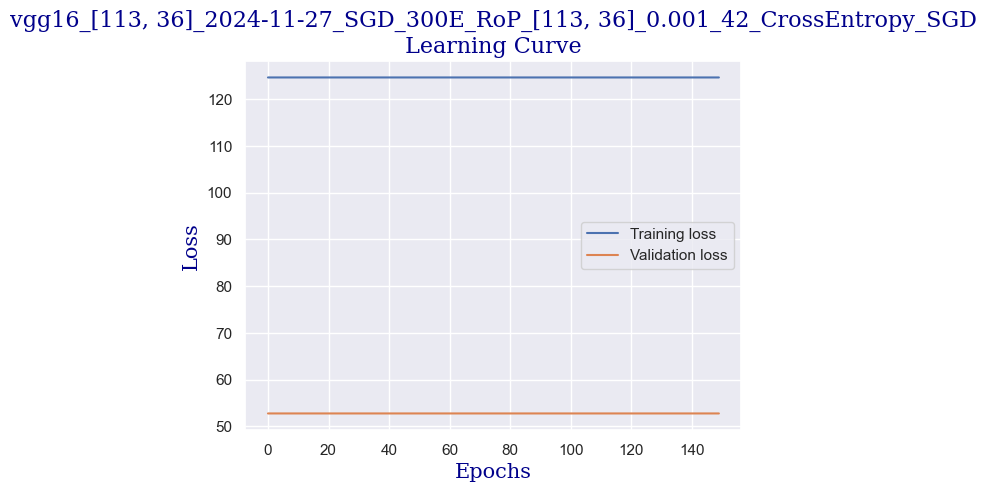

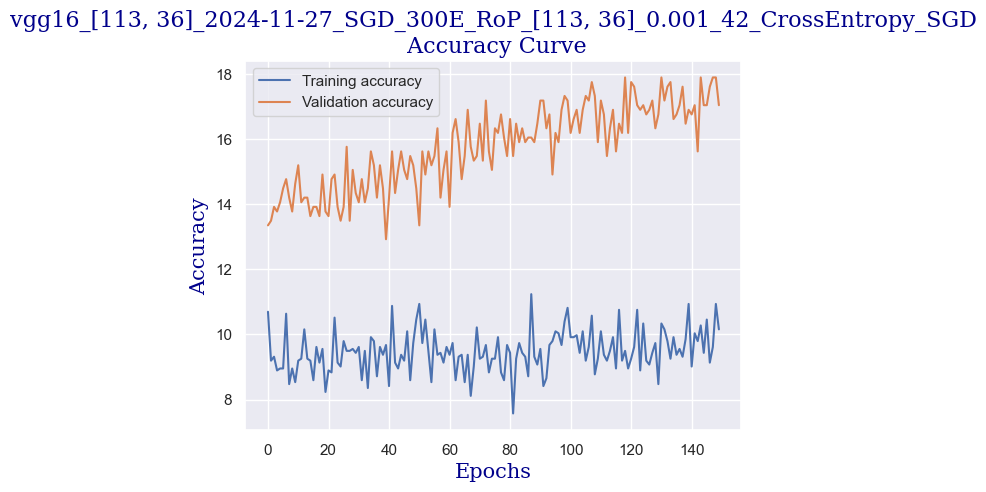

1024 1024


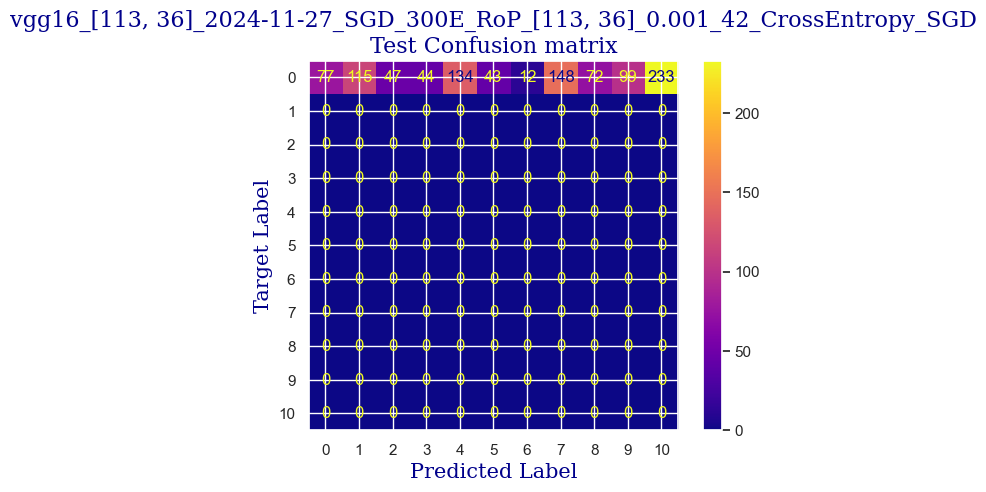

In [ ]:
_go(config)

In [ ]:
# 12.58 GiB. GPU 0 has a total capacty of 23.65 GiB of which 8.04 GiB is free
23.65-8.04


pred torch.Size([11])

lab  torch.Size([5, 11])

In [ ]:
m = choose_model('vgg16', 200704, 0)
print(m)

In [ ]:
# only things that have been added are more dictionary items

In [ ]:
!nvidia-smi

cuda memory error

currently trying to reduce number of vars and delete any large ones after use (del loss after loss has been added to current loss or loss list)

14.39  261124 - reducing batch size to 32

worked up to 160E.
will train to 150, then when all done, read in the model files and continue to 300.


In [ ]:
a=1
b=5
c=10
d= 15
mylist = [a, b, c]
print(mylist)
mylist.append(d)
print(mylist)

del d
print(mylist)
print(d)

In [ ]:
print(torch.cuda.memory_summary(device=device, abbreviated=False))